In [1]:
import sys
from outletsBiasRatings import outletsBiasRatingsAllSides,outletAbbreviationToFullName
import  matplotlib.pyplot as plt
from matplotlib.pyplot import *
import pandas as pd
import pickle
import time
from joblib import Parallel, delayed
from scipy import stats

In [2]:
outletsBiasRatings = outletsBiasRatingsAllSides
outlets = list(outletsBiasRatings.keys())

outletsL = [o for o in outlets if outletsBiasRatings[o] < 0]
outletsR = [o for o in outlets if outletsBiasRatings[o] > 0]
outletsC = [o for o in outlets if outletsBiasRatings[o] == 0]

print(len(outlets))
print("outletsAll" , outlets)
print("outletsL" , outletsL)
print("outletsC" , outletsC)
print("outletsR" , outletsR)

47
outletsAll ['alternet', 'democracynow', 'db', 'hp', 'theintercept', 'jacobin', 'motherjones', 'thenewyorker', 'thenation', 'slate', 'vox', 'cnn', 'nyt', 'abcnews', 'theatlantic', 'buzzfeed', 'cbs', 'economist', 'guardian', 'nbcnews', 'politico', 'timemagazine', 'wp', 'npr', 'ap', 'bbc', 'bloomberg', 'csm', 'reuters', 'thehill', 'usatoday', 'wsj', 'reason', 'we', 'wt', 'fox', 'americanspectator', 'bre', 'theblaze', 'cbn', 'dailycaller', 'dailymail', 'dailywire', 'thefederalist', 'nationalreview', 'nyp', 'newsmax']
outletsL ['alternet', 'democracynow', 'db', 'hp', 'theintercept', 'jacobin', 'motherjones', 'thenewyorker', 'thenation', 'slate', 'vox', 'cnn', 'nyt', 'abcnews', 'theatlantic', 'buzzfeed', 'cbs', 'economist', 'guardian', 'nbcnews', 'politico', 'timemagazine', 'wp', 'npr']
outletsC ['ap', 'bbc', 'bloomberg', 'csm', 'reuters', 'thehill', 'usatoday']
outletsR ['wsj', 'reason', 'we', 'wt', 'fox', 'americanspectator', 'bre', 'theblaze', 'cbn', 'dailycaller', 'dailymail', 'dailyw

## Load sentiment

In [3]:
# with open('sentimentDictionaryFromDistilbertSST2.pickle', 'rb') as handle:
with open('sentimentDictionaryRobertaLargeModel.pickle', 'rb') as handle:        
    sentimentDictionary = pickle.load(handle)

In [4]:
def getMatrixOfSentimentTimeSeriesInOutlets(sentimentDictionary,outlets,startYear,endYear):
    years=[str(year) for year in range(startYear,endYear+1)]
    m=np.zeros([len(outlets),len(years)])
    for outletIndex, outlet in enumerate(outlets):
        for yearIndex, year in enumerate(years):
            try:
                m[outletIndex,yearIndex]=sentimentDictionary[outlet][year]
            except KeyError:
                m[outletIndex,yearIndex]=np.nan
    return m

In [5]:
def getAverageSentimentAcrossOutlets(sentimentDictionary,outlets,startYear,endYear,z=1.96):
    m=getMatrixOfSentimentTimeSeriesInOutlets(sentimentDictionary,outlets,startYear,endYear)    
    
    xYears = [item for item in list(range(startYear, endYear + 1))]

    n = np.sum(~np.isnan(m), axis=0)  # number of obs in each time interval

    # Aggregate the metrics of several outlets
    mAverage = np.nanmean(m, axis=0)  # Proper way when nan values are present

    # Confidence intervals
    mStd = np.nanstd(m, axis=0)

    z = 1.96  # for a 95% C
    #     z = 2.58 # for a 99% C
    #     z = 3.291 # for a 99.9% C
    CI = z * (mStd / np.sqrt(n))
    
    stde = mStd / np.sqrt(n) #the standard error

    return (xYears, mAverage, CI, stde)
    

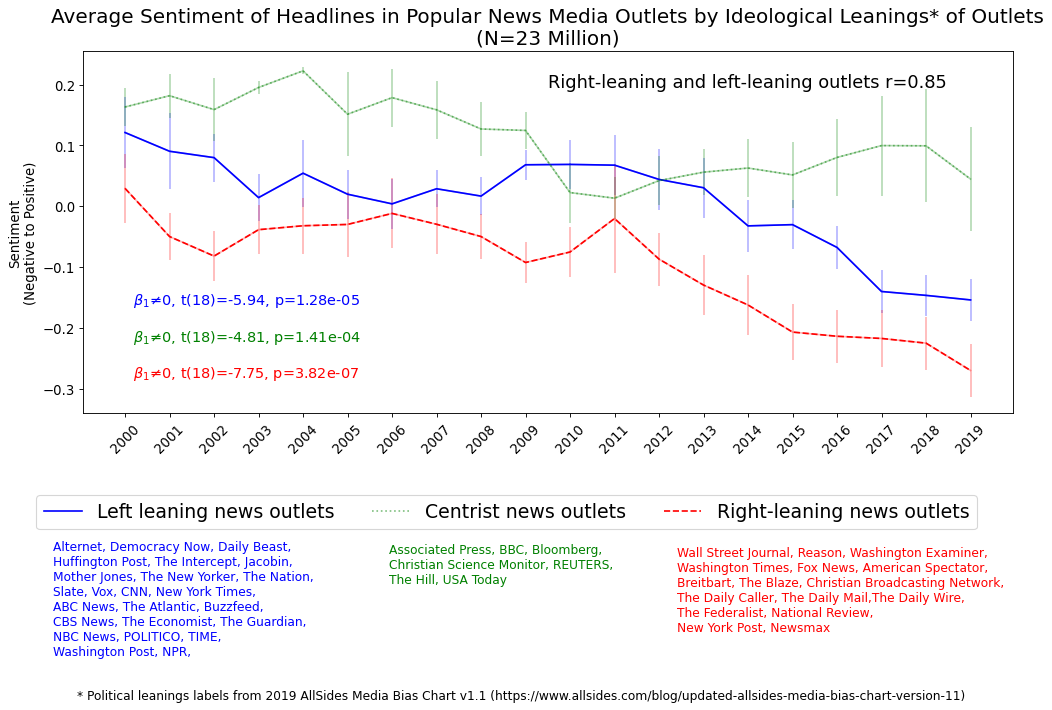

In [11]:
startYear=2000
endYear=2019
outlets = list(outletsBiasRatings.keys())

outletsL = [o for o in outlets if outletsBiasRatings[o] < 0]
outletsR = [o for o in outlets if outletsBiasRatings[o] > 0]
outletsC = [o for o in outlets if outletsBiasRatings[o] == 0]

years=[str(year) for year in range(startYear,endYear+1)]
yearsInts=[int(year) for year in years]

years,mAverageL, CIL, stdeL = getAverageSentimentAcrossOutlets(sentimentDictionary,outletsL,startYear,endYear,z=1.96)
years,mAverageC, CIC, stdeC = getAverageSentimentAcrossOutlets(sentimentDictionary,outletsC,startYear,endYear,z=1.96)
years,mAverageR, CIR, stdeR = getAverageSentimentAcrossOutlets(sentimentDictionary,outletsR,startYear,endYear,z=1.96)


figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(years,mAverageL,color="blue", label="Left leaning news outlets")
plt.errorbar(years, mAverageL, yerr=stdeL, color="blue", alpha= 0.3,capsize=0)

plt.plot(years,mAverageC,color="green", label="Centrist news outlets",alpha=0.5,linestyle=':')
plt.errorbar(years, mAverageC, yerr=stdeC, color="green", alpha= 0.3,capsize=0)

plt.plot(years,mAverageR,color="red", label="Right-leaning news outlets",linestyle='--')
plt.errorbar(years, mAverageR, yerr=stdeR, color="red", alpha= 0.3,capsize=0)

rRandL=np.corrcoef(mAverageL,mAverageR)[0][1]
plt.text(0.5,0.9,"Right-leaning and left-leaning outlets r="+str(rRandL)[:4],transform=plt.gca().transAxes,fontsize=16)

#Regression slope tests 
df=len(yearsInts)-2 #-2 Because we are estimating two coefficients
slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageL)
sL=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageC)
sC=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageR)
sR=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
plt.text(0.05,0.3,sL,transform=plt.gca().transAxes,fontsize=13,color="b")
plt.text(0.05,0.2,sC,transform=plt.gca().transAxes,fontsize=13,color="g")
plt.text(0.05,0.1,sR,transform=plt.gca().transAxes,fontsize=13,color="r")

plt.xticks(years,rotation=45,fontsize=12 )
plt.yticks(fontsize=12 )

outletsStringL="""Alternet, Democracy Now, Daily Beast,\nHuffington Post, The Intercept, Jacobin,\nMother Jones, The New Yorker, The Nation,\nSlate, Vox, CNN, New York Times,\nABC News, The Atlantic, Buzzfeed,\nCBS News, The Economist, The Guardian,\nNBC News, POLITICO, TIME,\nWashington Post, NPR,"""
outletsStringC="""Associated Press, BBC, Bloomberg,\nChristian Science Monitor, REUTERS,\nThe Hill, USA Today"""
outletsStringR="""Wall Street Journal, Reason, Washington Examiner,\nWashington Times, Fox News, American Spectator,\nBreitbart, The Blaze, Christian Broadcasting Network,\nThe Daily Caller, The Daily Mail,The Daily Wire,\nThe Federalist, National Review,\nNew York Post, Newsmax"""
figureTitle="Average Sentiment of Headlines in Popular News Media Outlets by Ideological Leanings* of Outlets\n(N=23 Million)"
plt.title(figureTitle,fontsize=18)
plt.ylabel("Sentiment\n(Negative to Positive)",fontsize=12)

plt.legend(loc=(-0.05,-0.32),ncol=3,fontsize=17)  

plt.figtext(0.10, -0.38, outletsStringL, horizontalalignment='left', fontsize=11, color='b')     
plt.figtext(0.38, -0.23, outletsStringC, horizontalalignment='left', fontsize=11, color='g')     
plt.figtext(0.62, -0.33, outletsStringR, horizontalalignment='left', fontsize=11, color='r')     

plt.figtext(0.12, -0.47, "* Political leanings labels from 2019 AllSides Media Bias Chart v1.1 (https://www.allsides.com/blog/updated-allsides-media-bias-chart-version-11)", horizontalalignment='left', fontsize=11, color='k')     

plt.savefig('../manuscript/figures/1-3sentimentOfHeadlinesByIdeology.png',dpi=400,bbox_inches='tight',pad_inches=0)#High-resolution    
   

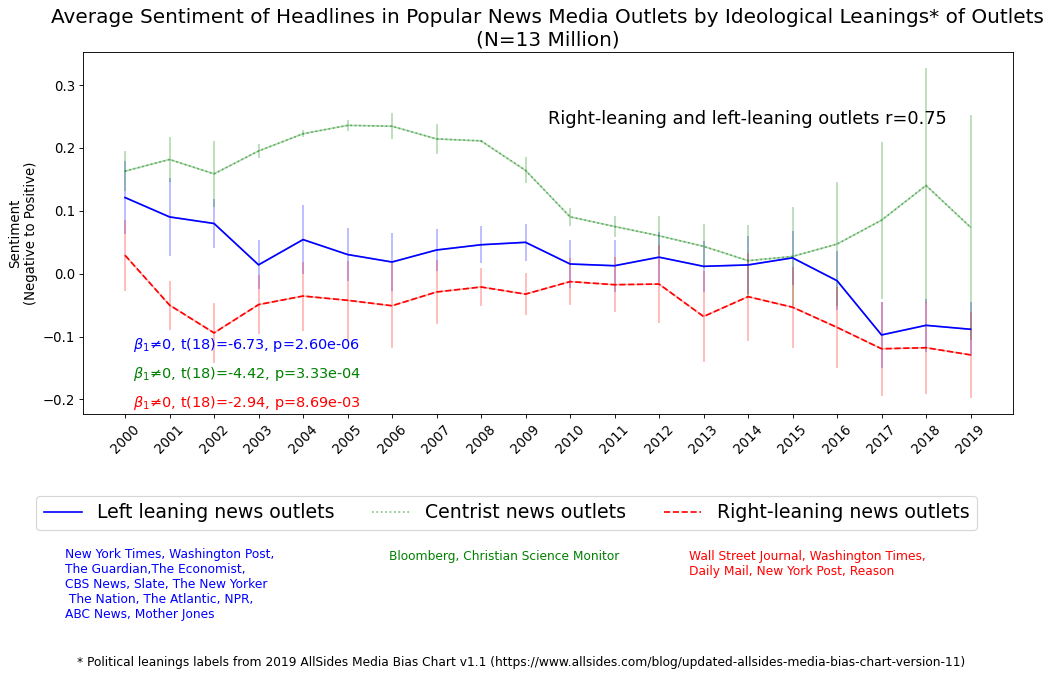

In [10]:
outlets = list(outletsBiasRatings.keys())
# outlets with headlines since 2000
outlets = ['nyp','dailymail','wt','wsj','csm','bloomberg','wp','guardian','economist','cbs','nyt','slate',
          'thenewyorker','thenation','theatlantic','reason','npr','abcnews','democracynow','motherjones'
          ]

outletsL = [o for o in outlets if outletsBiasRatings[o] < 0]
outletsR = [o for o in outlets if outletsBiasRatings[o] > 0]
outletsC = [o for o in outlets if outletsBiasRatings[o] == 0]

startYear=2000
years=[str(year) for year in range(startYear,endYear+1)]

years,mAverageL, CIL, stdeL = getAverageSentimentAcrossOutlets(sentimentDictionary,outletsL,startYear,endYear,z=1.96)
years,mAverageC, CIC, stdeC = getAverageSentimentAcrossOutlets(sentimentDictionary,outletsC,startYear,endYear,z=1.96)
years,mAverageR, CIR, stdeR = getAverageSentimentAcrossOutlets(sentimentDictionary,outletsR,startYear,endYear,z=1.96)

figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(years,mAverageL,color="blue", label="Left leaning news outlets")
plt.errorbar(years, mAverageL, yerr=stdeL, color="blue", alpha= 0.3,capsize=0)

plt.plot(years,mAverageC,color="green", label="Centrist news outlets",alpha=0.5,linestyle=':')
plt.errorbar(years, mAverageC, yerr=stdeC, color="green", alpha= 0.3,capsize=0)

plt.plot(years,mAverageR,color="red", label="Right-leaning news outlets",linestyle='--')
plt.errorbar(years, mAverageR, yerr=stdeR, color="red", alpha= 0.3,capsize=0)

rRandL=np.corrcoef(mAverageL,mAverageR)[0][1]
plt.text(0.5,0.8,"Right-leaning and left-leaning outlets r="+str(rRandL)[:4],transform=plt.gca().transAxes,fontsize=16)

#Regression slope tests 
df=len(yearsInts)-2 #-2 Because we are estimating two coefficients
slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageL)
sL=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageC)
sC=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageR)
sR=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
plt.text(0.05,0.18,sL,transform=plt.gca().transAxes,fontsize=13,color="b")
plt.text(0.05,0.10,sC,transform=plt.gca().transAxes,fontsize=13,color="g")
plt.text(0.05,0.02,sR,transform=plt.gca().transAxes,fontsize=13,color="r")

plt.xticks(years,rotation=45,fontsize=12 )
plt.yticks(fontsize=12 )

outlets = ['nyp','dailymail','wt','wsj','csm','bloomberg','wp','guardian','economist','cbs','nyt','slate']

outletsStringL="""New York Times, Washington Post,\nThe Guardian,The Economist,\nCBS News, Slate, The New Yorker\n The Nation, The Atlantic, NPR,\nABC News, Mother Jones"""
outletsStringC="""Bloomberg, Christian Science Monitor"""
outletsStringR="""Wall Street Journal, Washington Times,\nDaily Mail, New York Post, Reason"""
figureTitle="Average Sentiment of Headlines in Popular News Media Outlets by Ideological Leanings* of Outlets\n(N=13 Million)"
plt.title(figureTitle,fontsize=18)
plt.ylabel("Sentiment\n(Negative to Positive)",fontsize=12)

plt.legend(loc=(-0.05,-0.32),ncol=3,fontsize=17)  

plt.figtext(0.11, -0.3, outletsStringL, horizontalalignment='left', fontsize=11, color='b')     
plt.figtext(0.38, -0.18, outletsStringC, horizontalalignment='left', fontsize=11, color='g')     
plt.figtext(0.63, -0.21, outletsStringR, horizontalalignment='left', fontsize=11, color='r')     

plt.figtext(0.12, -0.40, "* Political leanings labels from 2019 AllSides Media Bias Chart v1.1 (https://www.allsides.com/blog/updated-allsides-media-bias-chart-version-11)", horizontalalignment='left', fontsize=11, color='k')     

plt.savefig('../manuscript/figures/sm/1-3sentimentOfHeadlinesByIdeologyOnlyOutletsWithArticlesSince2000.png',dpi=400,bbox_inches='tight',pad_inches=0)#High-resolution    
   